# King Count Sale Price Predictions #

* Morgan Didjurgis
* Flex 40 weeks
* Instructor: Abhineet Kulkarni




## Overview ##

This project uses King County sales data from 2014-2015 to build a linear model that predicts sales prices for single-family home buyers based on property features. 


### Business Problem ###

Single Family home buyers can benefit from tools to help them evaluate how much more or less different features/locations should cost.  This can help them narrow down homes to visit and also determine if a list price is reasonable before making an offer.

### Data Understanding ###

The data set used to fit the model is a list of ~18,000 properties sold in King County in 2014-2015 with accompanying prices and characteristics. The description of the column names can be found in 'column_names.md' in the data folder in this repo.

Most single family home buyers work with agents if they are not already very familiar with real estate.  Therefore, while I did aim to only include features  that the home buyer would care about, there are some features which improve accuracy that an agent may assist the home buyer in selecting or that an application might provide suggestions for based on averages in that city.

Throughout the process of model development, one must consider the tradeoff between ability to interpret the model and determine which features affect price most and the accuracy of the price prediction.  While it is useful to tell a buyer which features or locations are 'most expensive', it is often easier for actually see price predictions based on combinations of features.  I will prioritize the ability for a buyer to 'play' with different features and see predictions rather than having to compare 'impact' of those features. For this audience, actual price predictions are easier to comprehend and more user friendly.

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import requests
from bs4 import BeautifulSoup
%matplotlib inline

## Clean Data ##

Examine the data to determine if all columns are applicable to a single-family home pricing model. Identify null values and determine how to handle.
Prepare all features for modeling.

In [116]:
df=pd.read_csv('data/kc_house_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

waterfront and yr_renovated have null values that need to be addressed.

id, date, view are not applicable to a model for house pricing and will be removed

zipcode, lat, long will be replaced with a city column

In [117]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [118]:
#Examine timeframe homes were sold in
years=df['date'].apply(lambda x: int(x[-4:]))
years.describe()

count    21597.000000
mean      2014.322962
std          0.467619
min       2014.000000
25%       2014.000000
50%       2014.000000
75%       2015.000000
max       2015.000000
Name: date, dtype: float64

These homes were all sold in 2014 and 2015. This model would be most useful in 2015/2016, since the real estate market changes significantly over time.

### waterfront ###

For this variable, 1.0 represents waterfront properties and 0.0 represents not waterfront. Replace null values with 0, since we will assume they are not waterfront.

In [119]:
df['waterfront'].value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [120]:
#check number of null values
df['waterfront'].isnull().sum()

2376

In [121]:
#fill null values with 0.0
df['waterfront'].fillna(0.0,inplace=True)
df['waterfront'].value_counts()

0.0    21451
1.0      146
Name: waterfront, dtype: int64

### yr_renovated ###

Use the yr_renovated column to make a new column that distinguishes whether or not the house has been renovated. Value for 'renovated' will be 1 and 'not-renovated' will be 0. Null values and values of 0 in yr_renovated will assume to be 'not-renovated'.

In [122]:
df['yr_renovated'].isnull().sum()

3842

In [123]:
df['yr_renovated'].value_counts().head()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
Name: yr_renovated, dtype: int64

In [124]:
#create new series and fill null/zero values with 0.0 and all others with 1.0
ren_col=df['yr_renovated'].copy()
ren_col.fillna(0.0,inplace=True)
ren_col=ren_col.apply(lambda x: 1 if x!=0 else x)
ren_col.value_counts()

0.0    20853
1.0      744
Name: yr_renovated, dtype: int64

In [125]:
#add renovated column to df
df['renovated']=ren_col

### sqft_basement ###

Change this column to numeric values and create new column that denotes having a basement with value 1 and not having a basement with value 0.

In [126]:
df['sqft_basement'].value_counts().head()

0.0      12826
?          454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

Need to address '?' value. Will assume no basement.

In [127]:
df['sqft_basement'].value_counts().tail()

415.0     1
172.0     1
1248.0    1
3480.0    1
792.0     1
Name: sqft_basement, dtype: int64

In [128]:
#Make all '?' values 0.0
df['sqft_basement']=df['sqft_basement'].apply(lambda x:
                                             0.0 if x=='?' else x)
df['sqft_basement'].value_counts().head()

0.0      12826
0.0        454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

In [129]:
df['sqft_basement']=df['sqft_basement'].astype(float)
df['sqft_basement'].value_counts().head()

0.0      13280
600.0      217
500.0      209
700.0      208
800.0      201
Name: sqft_basement, dtype: int64

In [130]:
#For all homes with sqft_basement greater than 0, denote having basement with 1
df['basement']=df['sqft_basement'].apply(lambda x: 1 if x!=0 else x)
df['basement'].value_counts()

0.0    13280
1.0     8317
Name: basement, dtype: int64

### drop columns that aren't applicable ###

Id, date, and view are not applicable to this model so we will drop them.  We'll also drop yr_renovated and sqft_basement since the presence of 0 to denote not having the feature will affect the model.

In [131]:
df.drop(columns=['id','date','view','yr_renovated','sqft_basement'],
        inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  float64
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  int64  
 9   sqft_above     21597 non-null  int64  
 10  yr_built       21597 non-null  int64  
 11  zipcode        21597 non-null  int64  
 12  lat            21597 non-null  float64
 13  long           21597 non-null  float64
 14  sqft_living15  21597 non-null  int64  
 15  sqft_lot15     21597 non-null  int64  
 16  renovated      21597 non-null  float64
 17  basement       21597 non-null  float64
dtypes: flo

### Create city feature ###

Drop zipcode, lat, long after city created

Use BeautifulSoup to webscrape a list of cities corresponding to zipcodes in King County and create a dictionary of zipcodes and cities.

In [132]:
zip_url='https://www.zip-codes.com/county/wa-king.asp'
response=requests.get(zip_url)
soup=BeautifulSoup(response.content,'html.parser')

In [133]:
labels=soup.findAll('td',attrs={"class":"label"})
zip_city={}

for x in labels:
    class_a=x.find('a',attrs={"style":"text-decoration:underline;"})
    if class_a != None:
        title=class_a.get('title')
        zip_code=int(title[9:14])
        city=title[16:-4]
        zip_city[zip_code]=city

In [134]:
zip_city

{98001: 'AUBURN',
 98002: 'AUBURN',
 98003: 'FEDERAL WAY',
 98004: 'BELLEVUE',
 98005: 'BELLEVUE',
 98006: 'BELLEVUE',
 98007: 'BELLEVUE',
 98008: 'BELLEVUE',
 98009: 'BELLEVUE',
 98010: 'BLACK DIAMOND',
 98011: 'BOTHELL',
 98013: 'BURTON',
 98014: 'CARNATION',
 98015: 'BELLEVUE',
 98019: 'DUVALL',
 98022: 'ENUMCLAW',
 98023: 'FEDERAL WAY',
 98024: 'FALL CITY',
 98025: 'HOBART',
 98027: 'ISSAQUAH',
 98028: 'KENMORE',
 98029: 'ISSAQUAH',
 98030: 'KENT',
 98031: 'KENT',
 98032: 'KENT',
 98033: 'KIRKLAND',
 98034: 'KIRKLAND',
 98035: 'KENT',
 98038: 'MAPLE VALLEY',
 98039: 'MEDINA',
 98040: 'MERCER ISLAND',
 98041: 'BOTHELL',
 98042: 'KENT',
 98045: 'NORTH BEND',
 98047: 'PACIFIC',
 98050: 'PRESTON',
 98051: 'RAVENSDALE',
 98052: 'REDMOND',
 98053: 'REDMOND',
 98055: 'RENTON',
 98056: 'RENTON',
 98057: 'RENTON',
 98058: 'RENTON',
 98059: 'RENTON',
 98062: 'SEAHURST',
 98063: 'FEDERAL WAY',
 98064: 'KENT',
 98065: 'SNOQUALMIE',
 98070: 'VASHON',
 98071: 'AUBURN',
 98072: 'WOODINVILLE',
 98

In [135]:
#create city column
df['city']=df['zipcode'].map(zip_city)

In [136]:
df['city'].head()

0      SEATTLE
1      SEATTLE
2      KENMORE
3      SEATTLE
4    SAMMAMISH
Name: city, dtype: object

In [137]:
#drop zipcode, lat, long columns now that there is city column
df.drop(columns=['zipcode','lat','long'],inplace=True)

In [138]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,renovated,basement,city
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,1955,1340,5650,0.0,0.0,SEATTLE
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,1951,1690,7639,1.0,1.0,SEATTLE
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,1933,2720,8062,0.0,0.0,KENMORE
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,1965,1360,5000,0.0,1.0,SEATTLE
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,1987,1800,7503,0.0,0.0,SAMMAMISH


### Dummy variables for city ###

In [139]:
df['city'].value_counts()

SEATTLE          8973
RENTON           1597
BELLEVUE         1407
KENT             1201
KIRKLAND          977
REDMOND           977
AUBURN            911
SAMMAMISH         800
FEDERAL WAY       779
ISSAQUAH          733
MAPLE VALLEY      589
WOODINVILLE       471
SNOQUALMIE        308
KENMORE           283
MERCER ISLAND     282
ENUMCLAW          233
NORTH BEND        220
BOTHELL           195
DUVALL            190
CARNATION         124
VASHON            117
BLACK DIAMOND     100
FALL CITY          80
MEDINA             50
Name: city, dtype: int64

In [140]:
#create dummy variables for cities
#drop Seattle since it is the most common city, so that it is the reference

city_dummies=pd.get_dummies(df['city'])
city_dummies.drop(columns=['SEATTLE'],inplace=True)
city_dummies.head()

,AUBURN,BELLEVUE,BLACK DIAMOND,BOTHELL,CARNATION,DUVALL,ENUMCLAW,FALL CITY,FEDERAL WAY,ISSAQUAH,...,MAPLE VALLEY,MEDINA,MERCER ISLAND,NORTH BEND,REDMOND,RENTON,SAMMAMISH,SNOQUALMIE,VASHON,WOODINVILLE
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [141]:
df_model=pd.concat([df,city_dummies],axis=1)
df_model.drop(columns=['city'],inplace=True)
df_model.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,...,MAPLE VALLEY,MEDINA,MERCER ISLAND,NORTH BEND,REDMOND,RENTON,SAMMAMISH,SNOQUALMIE,VASHON,WOODINVILLE
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,...,0,0,0,0,0,0,0,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,...,0,0,0,0,0,0,1,0,0,0


## Build Linear Model ##

### Initial Model ###

In [142]:
X=df_model.drop(columns=['price'])
y=df_model['price']

In [143]:
#split test and train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,
                                                    random_state=40)

In [144]:
X_train_ols=sm.add_constant(X_train)
model=sm.OLS(y_train,X_train_ols)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     1254.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:31:31   Log-Likelihood:            -2.3464e+05
No. Observations:               17277   AIC:                         4.694e+05
Df Residuals:                   17239   BIC:                         4.697e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.182e+06   1.54e+05     27.231      0.000    3.88e+06    4.48e+06
bedrooms      -3.669e+04   2007.133    -18.280      0.000   -4.06e+04   -3.28e+04
bathrooms      3.911e+04   3500.073     11.173      0.000    3.22e+04     4.6e+04
sqft_living     163.0127      6.342     25.702      0.000     150.581     175.444
sqft_lot          0.1929      0.050      3.863      0.000       0.095       0.291
floors         2.292e+04   3955.249      5.795      0.000    1.52e+04    3.07e+04
waterfront     7.607e+05   1.78e+04     42.657      0.000    7.26e+05    7.96e+05
condition      2.498e+04   2532.957      9.862      0.000       2e+04    2.99e+04
grade          9.409e+04   2332.267     40.344      0.000    8.95e+04    9.87e+04
sqft_above        8.8306      7.008      1.260      0.208      -4.905      22.566
yr_built      -2440.6219     79.258    -30.793      0.000   -2595.976   -2285.268
sqft_living15    29.0370      3.706      7.834      0.000      21.772      36.302
sqft_lot15       -0.3632      0.080     -4.568      0.000      -0.519      -0.207
renovated       3.15e+04   8316.301      3.787      0.000    1.52e+04    4.78e+04
basement      -5061.1661   5421.219     -0.934      0.351   -1.57e+04    5564.974
AUBURN        -2.098e+05   7869.259    -26.657      0.000   -2.25e+05   -1.94e+05
BELLEVUE       1.277e+05   6737.991     18.949      0.000    1.14e+05    1.41e+05
BLACK DIAMOND   -1.3e+05   2.18e+04     -5.970      0.000   -1.73e+05   -8.73e+04
BOTHELL       -1.039e+05   1.58e+04     -6.587      0.000   -1.35e+05    -7.3e+04
CARNATION     -8.621e+04   1.97e+04     -4.370      0.000   -1.25e+05   -4.75e+04
DUVALL        -1.108e+05   1.61e+04     -6.903      0.000   -1.42e+05   -7.94e+04
ENUMCLAW      -1.708e+05   1.47e+04    -11.595      0.000      -2e+05   -1.42e+05
FALL CITY     -2.346e+04   2.42e+04     -0.968      0.333    -7.1e+04     2.4e+04
FEDERAL WAY   -2.444e+05   8362.136    -29.233      0.000   -2.61e+05   -2.28e+05
ISSAQUAH      -5.784e+04   8560.523     -6.756      0.000   -7.46e+04   -4.11e+04
KENMORE       -1.043e+05   1.31e+04     -7.961      0.000    -1.3e+05   -7.86e+04
KENT          -1.977e+05   7035.679    -28.102      0.000   -2.12e+05   -1.84e+05
KIRKLAND       5.489e+04   7625.052      7.199      0.000    3.99e+04    6.98e+04
MAPLE VALLEY  -1.731e+05   9846.848    -17.580      0.000   -1.92e+05   -1.54e+05
MEDINA         1.044e+06   3.11e+04     33.514      0.000    9.83e+05     1.1e+06
MERCER ISLAND  2.674e+05   1.37e+04     19.454      0.000     2.4e+05    2.94e+05
NORTH BEND    -1.024e+05   1.46e+04     -6.993      0.000   -1.31e+05   -7.37e+04
REDMOND        -1.44e+04   7899.579     -1.823      0.068   -2.99e+04    1084.397
RENTON        -1.481e+05   6320.019    -23.433      0.000    -1.6e+05   -1.36e+05
SAMMAMISH     -8.052e+04   8687.947     -9.268   

**Initial Model Results**

Initial R-squared value is .73 and all but basement, sqft_above, and two city dummies are significant to the .05 threshold.  There does appear to be issues with multicollinearity and the scale of the coefficients varies widely.  

The underlying distributions of the non-categorical variables tend to be right skewed, so performing a log transformation on these could increase normality.

Next step will be to perform log transformations on the non-categorical variables and scale them to using standardization.

### Log Transformation ###

Identify features that would benefit from log transformation.  Waterfront, basement, renovated, and city will not be considered for log transformation since they are categorical 1/0.

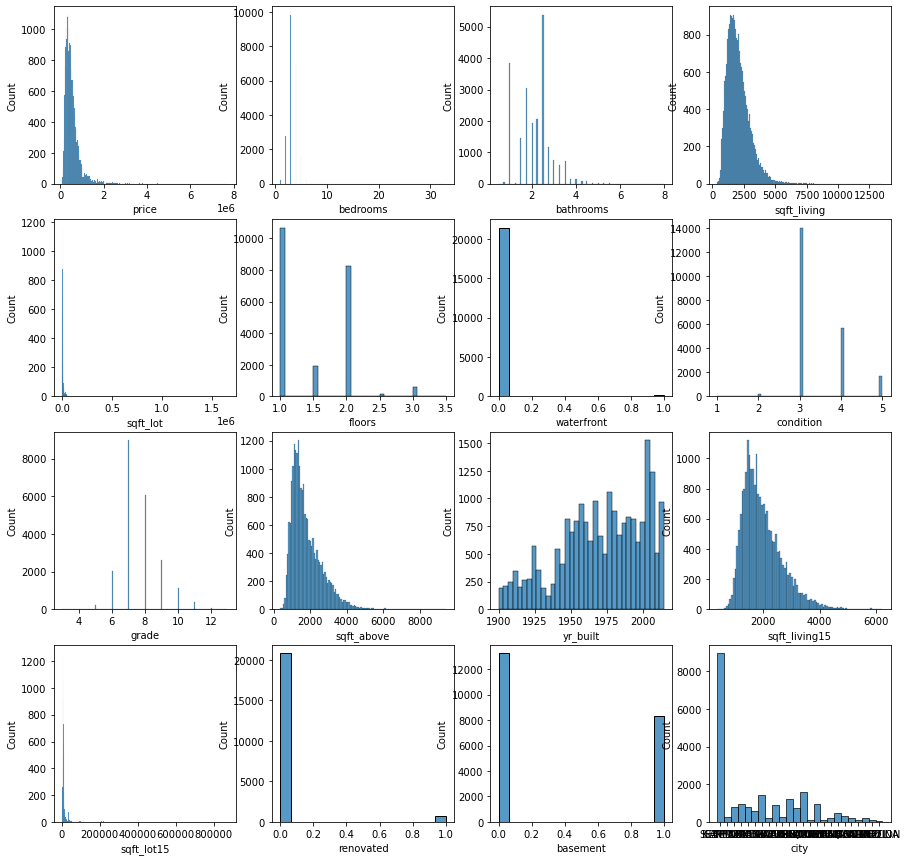

In [145]:
#Look at distribution of variables with histplot. 
#Log transformation could make right skewed distributions more normal

cols=df.columns

fig,axes=plt.subplots(4,4,figsize=(15,15))

for c,ax in enumerate(axes.flatten()):
    sns.histplot(data=df[cols[c]],ax=ax)

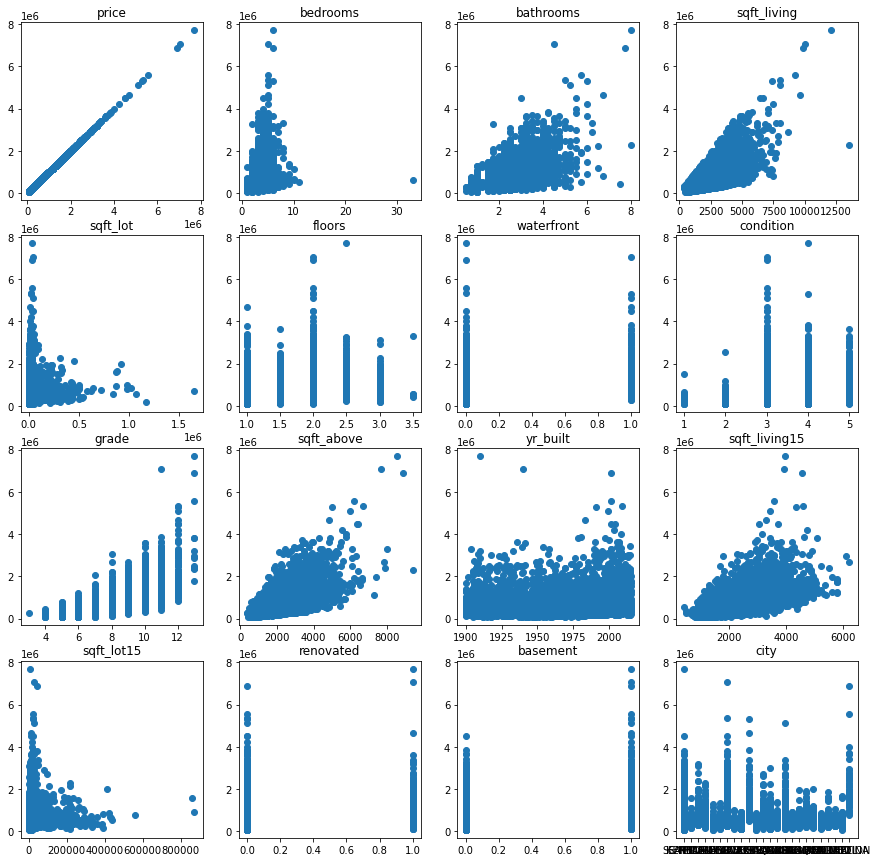

In [146]:
to_check=['sqft_living','bathrooms','sqft_lot',
          'floors','sqft_above','yr_built','sqft_living15','sqft_lot15']
#Check linearity of variables with price

fig,axes=plt.subplots(4,4,figsize=(15,15))

for n,ax in enumerate(axes.flatten()):
    x=df[cols[n]]
    ax.scatter(x,y)
    ax.set_title(cols[n])

**Choose features to log transform**

price, sqft_living, bathrooms, sqft_lot, floors, sqft_above, grade, sqft_living15, and sqft_lot15 all have right skew and could potentially benefit from a log transformation. We will test if log transformation for bedrooms and grade also makes the relationship with price more linear. 

Next, log transformation will be performed on these and re-check distribution and linearity.

In [147]:
to_log=['price','sqft_living','bathrooms','bedrooms','sqft_lot',
          'floors','sqft_above','sqft_living15','sqft_lot15','grade']
df_log=np.log(df_model[to_log])
y_log=np.log(y)

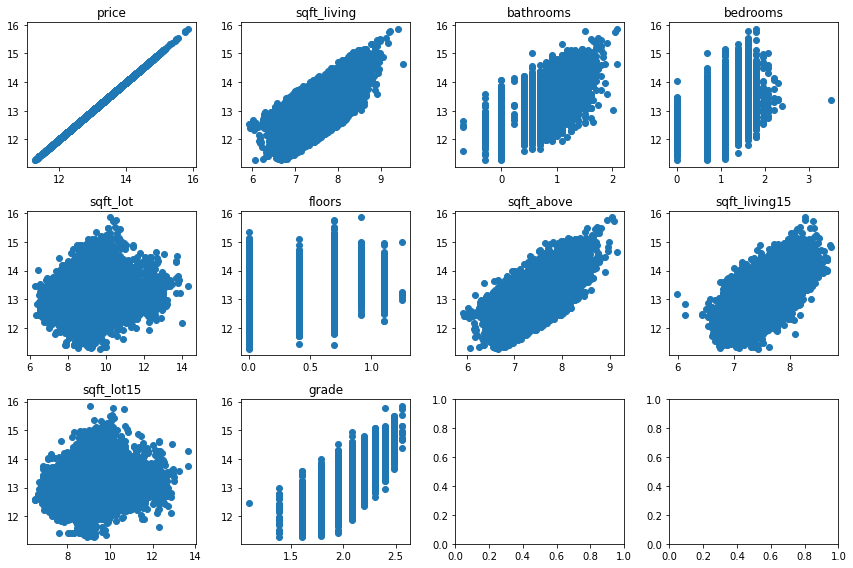

In [148]:
#Check linearity with price after tranformation
fig,axes=plt.subplots(3,4,figsize=(12,8))

for n,ax in enumerate(axes.flatten()[:-2]):
    x=df_log[to_log[n]]
    ax.scatter(x,y_log)
    ax.set_title(to_log[n])
    
plt.tight_layout()

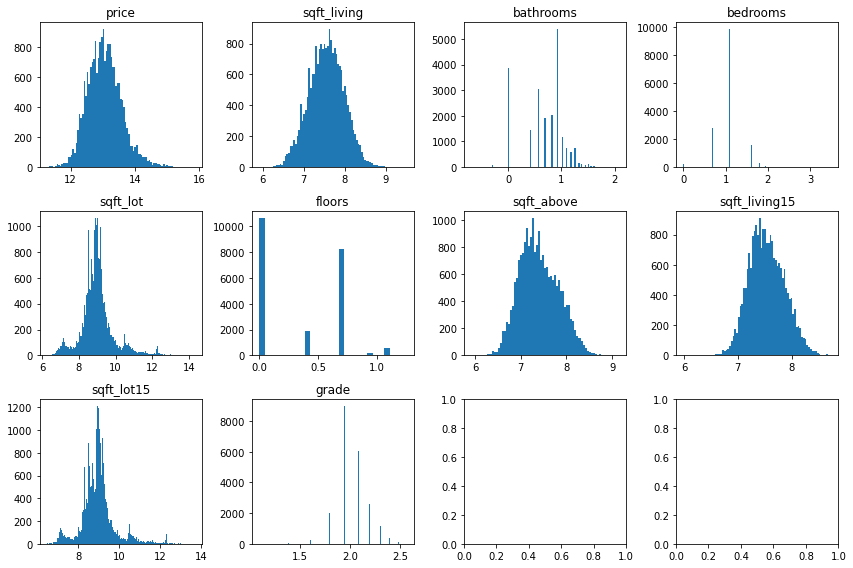

In [149]:
#check normality of distribution after log transformation
fig,axes=plt.subplots(3,4,figsize=(12,8))

for n,ax in enumerate(axes.flatten()[:-2]):
    x=df_log[to_log[n]]
    ax.hist(x,bins='auto')
    ax.set_title(to_log[n])
    
plt.tight_layout()

In [150]:
def prepare_data(X,y):
    
    """
    input X and y, with rows/columns already filtered
    does log transformation on required columns
    
    Returns transformed X, y
    """
    
    #log transform certain columnsin X
    to_log=['sqft_living','bathrooms','bedrooms','sqft_lot',
          'floors','sqft_above','sqft_living15','sqft_lot15','grade']
    
    cols=X.columns
    log_cols=[c for c in cols if c in to_log]
    log_df=np.log(X[log_cols])
    new_df=pd.concat([X.drop(columns=log_cols),log_df],axis=1)
    
    #add 'log' to transformed column names
    rename_dict={c:f'log_{c}' for c in log_cols}
    new_df.rename(columns=rename_dict,inplace=True)
    
    #scale certain columns
    #non_cat=['log_sqft_living','log_bathrooms','log_sqft_lot',
     #     'log_floors','log_sqft_above','yr_built',
      #   'log_bedrooms','condition','grade']
    #s_df=new_df[non_cat]
    #scale_df=(s_df-np.mean(s_df,axis=0))/np.sqrt(np.var(s_df,axis=0))
    #ls_df=pd.concat([new_df.drop(columns=non_cat),scale_df],axis=1)
    
    #log transform y (price)
    y_log=np.log(y)
     
    return new_df, y_log
    

Run regression for with log transformed features

In [151]:
#run log transformation on training data
X_train_log, y_train_log=prepare_data(X_train,y_train)

Log transformation increased R-squared by ~.05

In [152]:
X_train_log_ols=sm.add_constant(X_train_log)
model=sm.OLS(y_train_log,X_train_log_ols)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     1667.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:31:48   Log-Likelihood:                -282.45
No. Observations:               17277   AIC:                             640.9
Df Residuals:                   17239   BIC:                             935.7
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.7388      0.220     57.798      0.000      12.307      13.171
waterfront            0.5294      0.023     23.142      0.000       0.485       0.574
condition             0.0596      0.003     18.182      0.000       0.053       0.066
yr_built             -0.0034      0.000    -33.094      0.000      -0.004      -0.003
renovated             0.0539      0.011      5.030      0.000       0.033       0.075
basement              0.0748      0.008      9.603      0.000       0.060       0.090
AUBURN               -0.4901      0.010    -47.732      0.000      -0.510      -0.470
BELLEVUE              0.1860      0.009     21.345      0.000       0.169       0.203
BLACK DIAMOND        -0.1783      0.028     -6.330      0.000      -0.234      -0.123
BOTHELL              -0.1116      0.020     -5.496      0.000      -0.151      -0.072
CARNATION            -0.1032      0.026     -4.043      0.000      -0.153      -0.053
DUVALL               -0.1670      0.021     -8.035      0.000      -0.208      -0.126
ENUMCLAW             -0.3722      0.019    -19.622      0.000      -0.409      -0.335
FALL CITY             0.0423      0.031      1.357      0.175      -0.019       0.103
FEDERAL WAY          -0.5441      0.011    -50.237      0.000      -0.565      -0.523
ISSAQUAH             -0.0264      0.011     -2.385      0.017      -0.048      -0.005
KENMORE              -0.1345      0.017     -7.958      0.000      -0.168      -0.101
KENT                 -0.4537      0.009    -49.367      0.000      -0.472      -0.436
KIRKLAND              0.1082      0.010     10.967      0.000       0.089       0.128
MAPLE VALLEY         -0.3350      0.013    -26.222      0.000      -0.360      -0.310
MEDINA                0.7059      0.040     17.672      0.000       0.628       0.784
MERCER ISLAND         0.2932      0.018     16.620      0.000       0.259       0.328
NORTH BEND           -0.1178      0.019     -6.172      0.000      -0.155      -0.080
REDMOND               0.0719      0.010      7.014      0.000       0.052       0.092
RENTON               -0.2701      0.008    -32.836      0.000      -0.286      -0.254
SAMMAMISH            -0.0132      0.011     -1.176      0.240      -0.035       0.009
SNOQUALMIE           -0.1221      0.017     -7.337      0.000      -0.155      -0.089
VASHON               -0.0799      0.026     -3.049      0.002      -0.131      -0.029
WOODINVILLE          -0.0570      0.014     -4.032      0.000      -0.085      -0.029
log_bedrooms         -0.1255      0.009    -13.818      0.000      -0.143      -0.108
log_bathrooms         0.0938      0.009     10.587      0.000       0.076       0.111
log_sqft_living       0.2239      0.019     11.667      0.000       0.186       0.262
log_sqft_lot          0.0321      0.006      5.800      0.000       0.021

R-squared has increased and p-value of all but a couple city dummy variables are essentially zero. But multicollinearity is still an issue.

There are a number of related variables that could be causing the multicollinearity. Many of these are also not reasonable 'inputs' to expect from single family home buyers, since they would either not have the information to determine what the input should be or the information is more specific than what buyers should have in mind.

This includes sqft_living15, sqft_lot15, and sqft_above.

Grade and condition could also be related, but and we will try removing condition, since for each increase in condition unit, price unit only increases by 6% whereas it increases by 121% for grade.  Grade may be hard for buyers to input, but agents can help suggest the average grade value for single family homes or above average depending on importance of quality an budget of buyer.

## Address mulitcollinearity ##

Remove features to address multicollinearity as well as difficulty of providing inputs for single family home buyers.

In [153]:
#Remove sqft_living15, sqft_lot15, sqft_above and run model
X_train_1=X_train_log.drop(columns=['log_sqft_living15','log_sqft_lot15',
                                   'log_sqft_above'])

In [154]:
X_train_1_ols=sm.add_constant(X_train_1)
model=sm.OLS(y_train_log,X_train_1_ols)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     1721.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:31:48   Log-Likelihood:                -637.07
No. Observations:               17277   AIC:                             1344.
Df Residuals:                   17242   BIC:                             1616.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              14.0637      0.219     64.198      0.000      13.634      14.493
waterfront          0.5328      0.023     22.848      0.000       0.487       0.579
condition           0.0503      0.003     15.146      0.000       0.044       0.057
yr_built           -0.0037      0.000    -35.304      0.000      -0.004      -0.003
renovated           0.0340      0.011      3.122      0.002       0.013       0.055
basement            0.0170      0.005      3.406      0.001       0.007       0.027
AUBURN             -0.4789      0.010    -45.809      0.000      -0.499      -0.458
BELLEVUE            0.2211      0.009     25.274      0.000       0.204       0.238
BLACK DIAMOND      -0.1758      0.029     -6.129      0.000      -0.232      -0.120
BOTHELL            -0.0710      0.021     -3.436      0.001      -0.112      -0.031
CARNATION          -0.1195      0.026     -4.600      0.000      -0.170      -0.069
DUVALL             -0.1455      0.021     -6.875      0.000      -0.187      -0.104
ENUMCLAW           -0.3679      0.019    -19.043      0.000      -0.406      -0.330
FALL CITY           0.0352      0.032      1.108      0.268      -0.027       0.098
FEDERAL WAY        -0.5270      0.011    -47.815      0.000      -0.549      -0.505
ISSAQUAH            0.0048      0.011      0.427      0.669      -0.017       0.027
KENMORE            -0.1059      0.017     -6.157      0.000      -0.140      -0.072
KENT               -0.4309      0.009    -46.151      0.000      -0.449      -0.413
KIRKLAND            0.1297      0.010     12.942      0.000       0.110       0.149
MAPLE VALLEY       -0.3071      0.013    -23.669      0.000      -0.333      -0.282
MEDINA              0.7446      0.041     18.294      0.000       0.665       0.824
MERCER ISLAND       0.3436      0.018     19.243      0.000       0.309       0.379
NORTH BEND         -0.1242      0.019     -6.385      0.000      -0.162      -0.086
REDMOND             0.1061      0.010     10.248      0.000       0.086       0.126
RENTON             -0.2435      0.008    -29.251      0.000      -0.260      -0.227
SAMMAMISH           0.0301      0.011      2.674      0.007       0.008       0.052
SNOQUALMIE         -0.0634      0.017     -3.768      0.000      -0.096      -0.030
VASHON             -0.1130      0.027     -4.242      0.000      -0.165      -0.061
WOODINVILLE        -0.0331      0.014     -2.314      0.021      -0.061      -0.005
log_bedrooms       -0.1420      0.009    -15.358      0.000      -0.160      -0.124
log_bathrooms       0.0974      0.009     10.784      0.000       0.080       0.115
log_sqft_living     0.4545      0.011     43.231      0.000       0.434       0.475
log_sqft_lot       -0.0002      0.003     -0.076      0.939      -0.006       0.006
log_floors          0.1278      0.008     15.588      0.000

In [155]:
#Remove condition and run regression
X_train_2=X_train_1.drop(columns=['condition'])

In [156]:
X_train_2_ols=sm.add_constant(X_train_2)
model=sm.OLS(y_train_log,X_train_2_ols)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     1743.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:31:48   Log-Likelihood:                -751.25
No. Observations:               17277   AIC:                             1570.
Df Residuals:                   17243   BIC:                             1834.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              15.2822      0.205     74.509      0.000      14.880      15.684
waterfront          0.5354      0.023     22.808      0.000       0.489       0.581
yr_built           -0.0042   9.94e-05    -42.601      0.000      -0.004      -0.004
renovated           0.0060      0.011      0.558      0.577      -0.015       0.027
basement            0.0184      0.005      3.667      0.000       0.009       0.028
AUBURN             -0.4673      0.010    -44.528      0.000      -0.488      -0.447
BELLEVUE            0.2355      0.009     26.902      0.000       0.218       0.253
BLACK DIAMOND      -0.1588      0.029     -5.502      0.000      -0.215      -0.102
BOTHELL            -0.0713      0.021     -3.426      0.001      -0.112      -0.030
CARNATION          -0.1175      0.026     -4.491      0.000      -0.169      -0.066
DUVALL             -0.1463      0.021     -6.870      0.000      -0.188      -0.105
ENUMCLAW           -0.3434      0.019    -17.719      0.000      -0.381      -0.305
FALL CITY           0.0360      0.032      1.124      0.261      -0.027       0.099
FEDERAL WAY        -0.5213      0.011    -47.011      0.000      -0.543      -0.500
ISSAQUAH            0.0134      0.011      1.186      0.236      -0.009       0.036
KENMORE            -0.1042      0.017     -6.016      0.000      -0.138      -0.070
KENT               -0.4165      0.009    -44.551      0.000      -0.435      -0.398
KIRKLAND            0.1373      0.010     13.626      0.000       0.118       0.157
MAPLE VALLEY       -0.2999      0.013    -22.974      0.000      -0.325      -0.274
MEDINA              0.7525      0.041     18.367      0.000       0.672       0.833
MERCER ISLAND       0.3660      0.018     20.436      0.000       0.331       0.401
NORTH BEND         -0.1219      0.020     -6.223      0.000      -0.160      -0.084
REDMOND             0.1108      0.010     10.642      0.000       0.090       0.131
RENTON             -0.2302      0.008    -27.622      0.000      -0.247      -0.214
SAMMAMISH           0.0334      0.011      2.949      0.003       0.011       0.056
SNOQUALMIE         -0.0631      0.017     -3.724      0.000      -0.096      -0.030
VASHON             -0.0930      0.027     -3.472      0.001      -0.145      -0.040
WOODINVILLE        -0.0255      0.014     -1.769      0.077      -0.054       0.003
log_bedrooms       -0.1383      0.009    -14.868      0.000      -0.157      -0.120
log_bathrooms       0.1098      0.009     12.133      0.000       0.092       0.128
log_sqft_living     0.4550      0.011     42.996      0.000       0.434       0.476
log_sqft_lot       -0.0015      0.003     -0.500      0.617      -0.007       0.004
log_floors          0.1175      0.008     14.284      0.000       0.101       0.134
log_grade           1.3793      0.022     62.014      0.000

### Examine Variance Inflation Factors ###

In [157]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,renovated,basement
price,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.264306,0.036056,0.667951,0.605368,0.053953,0.585241,0.082845,0.117543,0.178264
bedrooms,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002127,0.026496,0.356563,0.479386,0.155670,0.393406,0.030690,0.017635,0.158412
bathrooms,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.063629,-0.126479,0.665838,0.686668,0.507173,0.569884,0.088303,0.046742,0.159863
sqft_living,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.104637,-0.059445,0.762779,0.876448,0.318152,0.756402,0.184342,0.050829,0.201198
sqft_lot,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.021459,-0.008830,0.114731,0.184139,0.052946,0.144763,0.718204,0.005091,-0.034889
floors,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.020797,-0.264075,0.458794,0.523989,0.489193,0.280102,-0.010722,0.003713,-0.252465
waterfront,0.264306,-0.002127,0.063629,0.104637,0.021459,0.020797,1.000000,0.016648,0.082818,0.071778,-0.024487,0.083823,0.030658,0.074267,0.039220
condition,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.016648,1.000000,-0.146896,-0.158904,-0.361592,-0.093072,-0.003126,-0.055383,0.130542
grade,0.667951,0.356563,0.665838,0.762779,0.114731,0.458794,0.082818,-0.146896,1.000000,0.756073,0.447865,0.713867,0.120981,0.015259,0.050701
sqft_above,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,0.071778,-0.158904,0.756073,1.000000,0.424037,0.731767,0.195077,0.020566,-0.207268


We can use the Variance Inflation Factor to explore which variables have issues with multicollinearity.  This is important to the interpretability of the model.  Currently, the model's coefficients are not all reliable as indicators of which features are driving increase in sales price because of multicollinearity.  For example, log_bedrooms and log_sqft_lot both have negative coefficients which indications that for each percent increase in bedrooms or sqft_lot there is a negative percent increase in sales price.  Just from basic real estate knowledge, we know this doesn't make sense.  Although the model is still providing reliable results based on the data, we are not able to rely on the coefficients to explain to buyers what features are most important to price.

Below, I explore VIF and determine which features can be removed to address multicollinearity.  However, removing features comes at the cost of reducing R-squared and overall accuracy of the model.  Therefore, I will have to determine if the loss in accuracy is worth the increase in interpretability.

I explored many combinations of features and below are the features that must be dropped to address all multicollinearity and bring all features' VIFs below 5.

In [158]:
vif_data=pd.DataFrame()
vif_data['feature']=sm.add_constant(X_train_2).columns

vif_data['VIF']=[variance_inflation_factor(sm.add_constant(X_train_2).values,i) 
                 for i in range(len(sm.add_constant(X_train_2).columns))]
vif_data

,feature,VIF
0,const,11357.166685
1,waterfront,1.043041
2,yr_built,2.307155
3,renovated,1.098125
4,basement,1.611204
5,AUBURN,1.211306
6,BELLEVUE,1.266050
7,BLACK DIAMOND,1.049151
8,BOTHELL,1.038669
9,CARNATION,1.073551


In [159]:
test=X_train_2.drop(columns=['yr_built','log_sqft_lot','log_bedrooms',
                             'log_grade','log_bathrooms','basement'])
vif_data=pd.DataFrame()
vif_data['feature']=sm.add_constant(test).columns

vif_data['VIF']=[variance_inflation_factor(sm.add_constant(test).values,i) 
                 for i in range(len(sm.add_constant(test).columns))]
vif_data

,feature,VIF
0,const,410.303384
1,waterfront,1.033825
2,renovated,1.024081
3,AUBURN,1.061747
4,BELLEVUE,1.163136
5,BLACK DIAMOND,1.007873
6,BOTHELL,1.017221
7,CARNATION,1.009131
8,DUVALL,1.016572
9,ENUMCLAW,1.015930


In [160]:
test_ols=sm.add_constant(test)
model=sm.OLS(y_train_log,test_ols)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     1486.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:31:50   Log-Likelihood:                -3042.8
No. Observations:               17277   AIC:                             6142.
Df Residuals:                   17249   BIC:                             6359.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.5452      0.045    169.530      0.000       7.458       7.632
waterfront          0.6228      0.027     23.343      0.000       0.571       0.675
renovated           0.1120      0.012      9.390      0.000       0.089       0.135
AUBURN             -0.6070      0.011    -54.107      0.000      -0.629      -0.585
BELLEVUE            0.2365      0.010     24.691      0.000       0.218       0.255
BLACK DIAMOND      -0.3147      0.032     -9.746      0.000      -0.378      -0.251
BOTHELL            -0.1729      0.024     -7.358      0.000      -0.219      -0.127
CARNATION          -0.2616      0.029     -9.036      0.000      -0.318      -0.205
DUVALL             -0.3176      0.024    -13.389      0.000      -0.364      -0.271
ENUMCLAW           -0.4616      0.021    -21.568      0.000      -0.504      -0.420
FALL CITY          -0.0812      0.036     -2.273      0.023      -0.151      -0.011
FEDERAL WAY        -0.6021      0.012    -49.298      0.000      -0.626      -0.578
ISSAQUAH           -0.0484      0.012     -3.903      0.000      -0.073      -0.024
KENMORE            -0.1980      0.020    -10.143      0.000      -0.236      -0.160
KENT               -0.5532      0.010    -56.017      0.000      -0.573      -0.534
KIRKLAND            0.0707      0.011      6.365      0.000       0.049       0.093
MAPLE VALLEY       -0.4746      0.014    -33.825      0.000      -0.502      -0.447
MEDINA              0.8398      0.047     18.017      0.000       0.748       0.931
MERCER ISLAND       0.4088      0.020     20.190      0.000       0.369       0.448
NORTH BEND         -0.2321      0.022    -10.779      0.000      -0.274      -0.190
REDMOND             0.0357      0.011      3.219      0.001       0.014       0.058
RENTON             -0.3521      0.009    -39.960      0.000      -0.369      -0.335
SAMMAMISH           0.0055      0.012      0.449      0.653      -0.018       0.029
SNOQUALMIE         -0.2461      0.019    -13.098      0.000      -0.283      -0.209
VASHON             -0.1756      0.030     -5.934      0.000      -0.234      -0.118
WOODINVILLE        -0.0695      0.015     -4.487      0.000      -0.100      -0.039
log_sqft_living     0.7368      0.006    120.682      0.000       0.725       0.749
log_floors          0.1385      0.007     19.880      0.000       0.125       0.152
==============================================================================
Omnibus:                      413.963   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              966.767
Skew:                          -0.044   Prob(JB):                    1.17e-210
Kurtosis:                       4.156   Cond. No.                         168.
==============================================================================

Note

In [161]:
#Calculate percent increase in price if house is waterfront
(np.exp(.6228)-1)*100

86.41403341673974

In [162]:
#Calculate percent increase in price if house has a basement
(np.exp(.1120)-1)*100

11.851286064504517

In [163]:
#Calculate percent in increase in price with 1500sqft to 2000sqft
percent_inc=(500/1500)*100
price_per_inc=percent_inc*.73
price_per_inc
percent_inc

33.33333333333333

After addressing multicollinearity, we can see that the most important non-city features are log_sqft_living (0.73% increase in price for every 1% increase in sqft_living), waterfront, and renovated.

For sqft_living example- if house went from 1500sqft to 2000sqft (33% increase), the price would increase by 24%

For waterfront, 1 unit increase corresponds to 86% price increase, which means a waterfront property should cost 86% more than the same property not waterfront.

For renovated, a renovated property costs 12% more than a non-renovated property.


However, removing features to make the model more interpretable did cause r-squared to drop from .77 to .69.  This means that 8% less of the price variance from mean is explainable using the model.  If the goal is to provide accurate predictions to single-family home buyers, then this is not a good trade-off.  However, we can still explain which neighborhoods have the most significant affect on price since these features did not have any multicollinearity issues in the original model.  

For this model, I will accept the issues with multicollinearity in order to make the model more accurate and limit my interpretation of coefficients to those features not affected. This includes waterfront, renovated, basement, and city.

## Single family home criteria ##

We've examined the effects of log transformations and multicollinearity.

Now we will examine what happens to the model when we filter the original data set to remove homes that are obviously not single-family. This will remove outliers and also narrow the scope of the model to apply more directly to single-family homes.

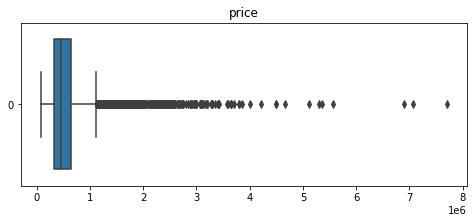

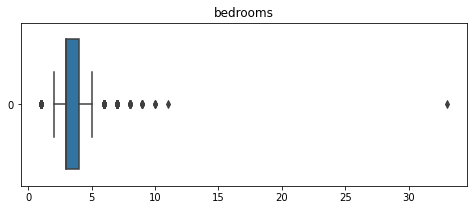

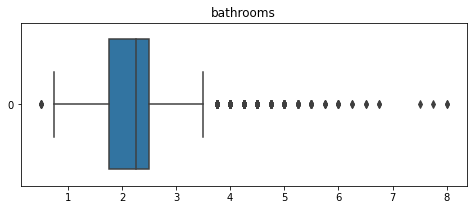

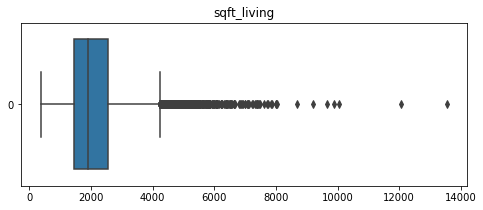

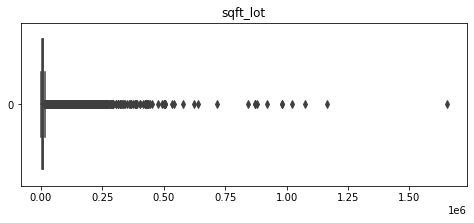

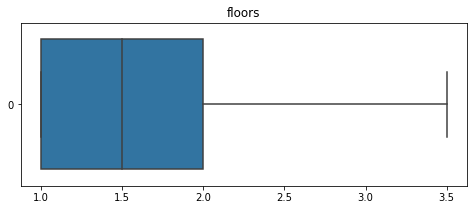

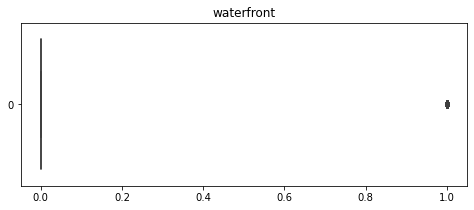

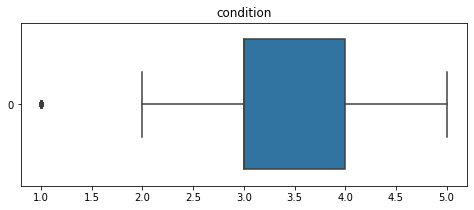

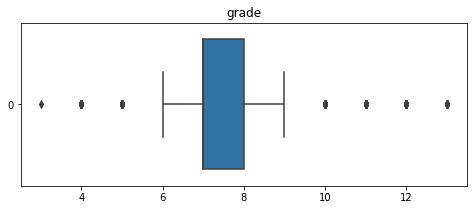

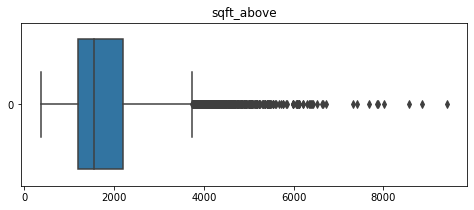

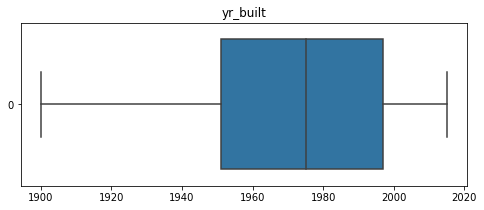

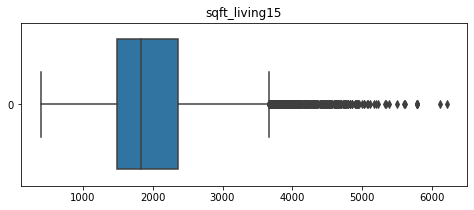

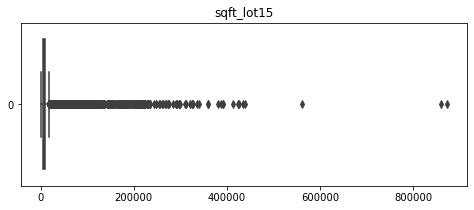

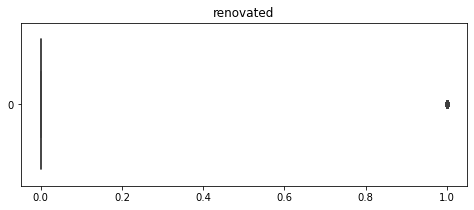

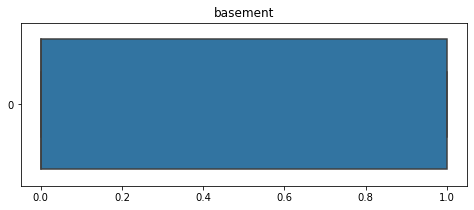

In [164]:
#Use boxplots to look at distribution of features and examine outliers

cols=df.columns

for c in cols[:-1]:
    fig,ax=plt.subplots(figsize=(8,3))
    sns.boxplot(data=df[c],orient='h',ax=ax)
    ax.set_title(c)

There appear to be houses in the data set that would not apply to single-family home buyers.  

I'll start by including only houses with 5 or less bedrooms, removing all low outliers for condition and grade, and removing any sqft_lot above 500,000 then check to see how price, bathroom, sqft_living are affected.

In [165]:
df_sf=df_model.copy()
df_sf=df_model[df_model['bedrooms']<=5]
df_sf=df_model[(df_model['condition']>2.0)&(df_model['grade']>6.0)]
df_sf=df_model[df_model['sqft_lot']<500000]

In [166]:
df_sf.drop(columns=['sqft_above','sqft_living15','sqft_lot15','condition'],
          inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [167]:
df_sf.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'grade', 'yr_built', 'renovated', 'basement', 'AUBURN',
       'BELLEVUE', 'BLACK DIAMOND', 'BOTHELL', 'CARNATION', 'DUVALL',
       'ENUMCLAW', 'FALL CITY', 'FEDERAL WAY', 'ISSAQUAH', 'KENMORE', 'KENT',
       'KIRKLAND', 'MAPLE VALLEY', 'MEDINA', 'MERCER ISLAND', 'NORTH BEND',
       'REDMOND', 'RENTON', 'SAMMAMISH', 'SNOQUALMIE', 'VASHON',
       'WOODINVILLE'],
      dtype='object')

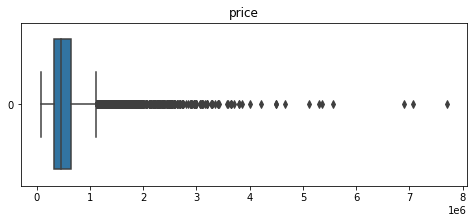

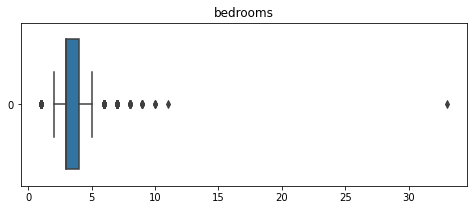

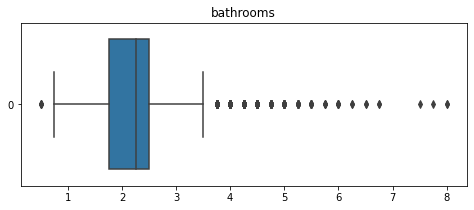

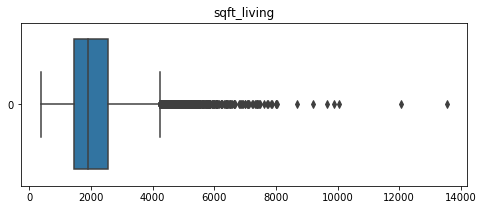

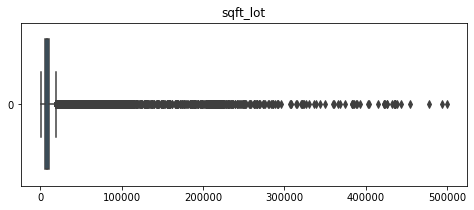

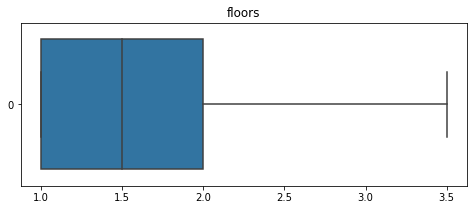

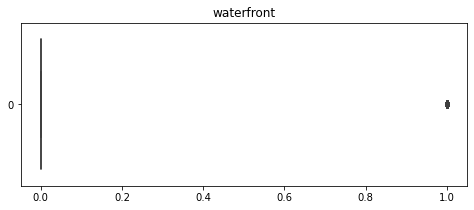

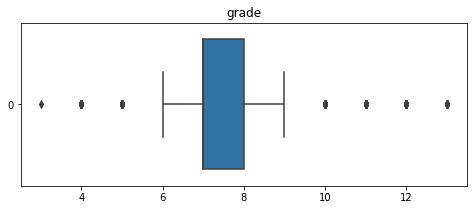

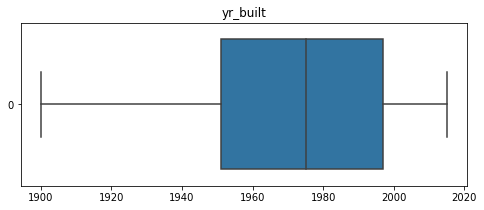

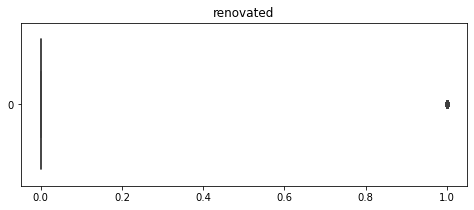

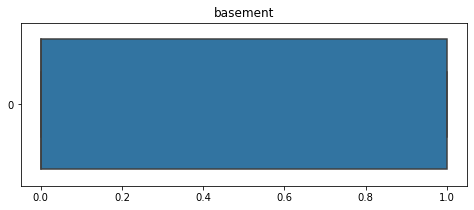

In [168]:
cols=['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'grade', 'yr_built', 'renovated', 'basement']
for c in cols:
    fig,ax=plt.subplots(figsize=(8,3))
    sns.boxplot(data=df_sf[c],orient='h',ax=ax)
    ax.set_title(c)

For now we won't filter out any more houses so that the model has enough data to train on and we don't rule out buyers who want to buy larger homes.

In [169]:
#create X and y matrices and log transform applicable variables
X_sf=df_sf.drop(columns=['price'])
y_sf=df_sf['price']

X_sf,y_sf=prepare_data(X_sf,y_sf)
X_sf.head()

,waterfront,yr_built,renovated,basement,AUBURN,BELLEVUE,BLACK DIAMOND,BOTHELL,CARNATION,DUVALL,...,SAMMAMISH,SNOQUALMIE,VASHON,WOODINVILLE,log_bedrooms,log_bathrooms,log_sqft_living,log_sqft_lot,log_floors,log_grade
0,0.0,1955,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,1.098612,0.000000,7.073270,8.639411,0.000000,1.945910
1,0.0,1951,1.0,1.0,0,0,0,0,0,0,...,0,0,0,0,1.098612,0.810930,7.851661,8.887653,0.693147,1.945910
2,0.0,1933,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0.693147,0.000000,6.646391,9.210340,0.000000,1.791759
3,0.0,1965,0.0,1.0,0,0,0,0,0,0,...,0,0,0,0,1.386294,1.098612,7.580700,8.517193,0.000000,1.945910
4,0.0,1987,0.0,0.0,0,0,0,0,0,0,...,1,0,0,0,1.098612,0.693147,7.426549,8.997147,0.000000,2.079442


In [170]:
#train-test split sf data
Xsf_train, Xsf_test, ysf_train, ysf_test = train_test_split(X_sf,y_sf,
                                                            test_size=.2,
                                                            random_state=40)

In [171]:
X_train_ols=sm.add_constant(Xsf_train)
model=sm.OLS(ysf_train,X_train_ols)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     1726.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:31:52   Log-Likelihood:                -752.33
No. Observations:               17260   AIC:                             1573.
Df Residuals:                   17226   BIC:                             1836.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              15.2897      0.205     74.431      0.000      14.887      15.692
waterfront          0.5444      0.025     22.204      0.000       0.496       0.592
yr_built           -0.0042   9.98e-05    -42.459      0.000      -0.004      -0.004
renovated           0.0002      0.011      0.014      0.989      -0.021       0.022
basement            0.0176      0.005      3.512      0.000       0.008       0.027
AUBURN             -0.4651      0.010    -44.619      0.000      -0.486      -0.445
BELLEVUE            0.2439      0.009     27.682      0.000       0.227       0.261
BLACK DIAMOND      -0.1815      0.029     -6.303      0.000      -0.238      -0.125
BOTHELL            -0.0747      0.021     -3.604      0.000      -0.115      -0.034
CARNATION          -0.0980      0.027     -3.589      0.000      -0.151      -0.044
DUVALL             -0.1353      0.022     -6.267      0.000      -0.178      -0.093
ENUMCLAW           -0.3548      0.019    -18.375      0.000      -0.393      -0.317
FALL CITY           0.0132      0.032      0.411      0.681      -0.050       0.076
FEDERAL WAY        -0.5141      0.011    -46.518      0.000      -0.536      -0.492
ISSAQUAH            0.0173      0.011      1.535      0.125      -0.005       0.039
KENMORE            -0.0955      0.017     -5.615      0.000      -0.129      -0.062
KENT               -0.4166      0.009    -44.102      0.000      -0.435      -0.398
KIRKLAND            0.1390      0.010     13.833      0.000       0.119       0.159
MAPLE VALLEY       -0.2918      0.013    -22.586      0.000      -0.317      -0.267
MEDINA              0.7714      0.040     19.312      0.000       0.693       0.850
MERCER ISLAND       0.3610      0.018     20.280      0.000       0.326       0.396
NORTH BEND         -0.1145      0.020     -5.743      0.000      -0.154      -0.075
REDMOND             0.1089      0.011     10.324      0.000       0.088       0.130
RENTON             -0.2280      0.008    -27.237      0.000      -0.244      -0.212
SAMMAMISH           0.0355      0.011      3.127      0.002       0.013       0.058
SNOQUALMIE         -0.0482      0.017     -2.856      0.004      -0.081      -0.015
VASHON             -0.1099      0.028     -3.950      0.000      -0.164      -0.055
WOODINVILLE        -0.0193      0.014     -1.347      0.178      -0.047       0.009
log_bedrooms       -0.1356      0.009    -14.642      0.000      -0.154      -0.117
log_bathrooms       0.1116      0.009     12.369      0.000       0.094       0.129
log_sqft_living     0.4530      0.011     42.927      0.000       0.432       0.474
log_sqft_lot       -0.0023      0.003     -0.745      0.456      -0.008       0.004
log_floors          0.1125      0.008     13.613      0.000       0.096       0.129
log_grade           1.3876      0.022     62.565      0.000

R-squared is essentially the same when data is filtered (.001 less).  Since there is no perceivable difference from removing outliers, we'll keep all the data.

## Recursive Feature Elimination ##

I'll use RFE and stepwise feature selection to test if removing certain features increases r-squared.

In [172]:
linreg_=LinearRegression()
#run for top half of features
selector=RFE(linreg_)
selector=selector.fit(X_train_2,y_train_log)

In [173]:
selected=selector.support_

In [174]:
len(X_train_2.columns)

33

In [175]:
{c:b for c,b in zip(X_train_2.columns,selected)}

{'waterfront': True,
 'yr_built': False,
 'renovated': False,
 'basement': False,
 'AUBURN': True,
 'BELLEVUE': True,
 'BLACK DIAMOND': True,
 'BOTHELL': False,
 'CARNATION': True,
 'DUVALL': True,
 'ENUMCLAW': True,
 'FALL CITY': False,
 'FEDERAL WAY': True,
 'ISSAQUAH': False,
 'KENMORE': False,
 'KENT': True,
 'KIRKLAND': False,
 'MAPLE VALLEY': True,
 'MEDINA': True,
 'MERCER ISLAND': True,
 'NORTH BEND': True,
 'REDMOND': False,
 'RENTON': True,
 'SAMMAMISH': False,
 'SNOQUALMIE': False,
 'VASHON': False,
 'WOODINVILLE': False,
 'log_bedrooms': False,
 'log_bathrooms': False,
 'log_sqft_living': True,
 'log_sqft_lot': False,
 'log_floors': False,
 'log_grade': True}

In [176]:
#try model with just cities, sqft_living, grade, and waterfront
X_train_RFE=X_train_2.drop(columns=['log_bedrooms','yr_built',
                            'log_floors','log_sqft_lot','log_bathrooms',
                            'renovated','basement'])

#fit data and get r2
linreg.fit(X_train_RFE, y_train_log)
y_hat_train=linreg.predict(X_train_RFE)

r2=r2_score(y_train_log,y_hat_train)
print(f'r2: {r2}')

r2: 0.7399786851283308


In [177]:
#Keep 3/4 of features
selector=RFE(linreg_,n_features_to_select=26)
selector=selector.fit(X_train_2,y_train_log)
selected=selector.support_
{c:b for c,b in zip(X_train_2.columns,selected)}

{'waterfront': True,
 'yr_built': False,
 'renovated': True,
 'basement': False,
 'AUBURN': True,
 'BELLEVUE': True,
 'BLACK DIAMOND': True,
 'BOTHELL': True,
 'CARNATION': True,
 'DUVALL': True,
 'ENUMCLAW': True,
 'FALL CITY': True,
 'FEDERAL WAY': True,
 'ISSAQUAH': True,
 'KENMORE': True,
 'KENT': True,
 'KIRKLAND': False,
 'MAPLE VALLEY': True,
 'MEDINA': True,
 'MERCER ISLAND': True,
 'NORTH BEND': True,
 'REDMOND': False,
 'RENTON': True,
 'SAMMAMISH': True,
 'SNOQUALMIE': True,
 'VASHON': True,
 'WOODINVILLE': True,
 'log_bedrooms': True,
 'log_bathrooms': False,
 'log_sqft_living': True,
 'log_sqft_lot': False,
 'log_floors': False,
 'log_grade': True}

In [178]:
#try model with just cities, sqft_living, grade, and waterfront
X_train_RFE=X_train_2.drop(columns=['yr_built',
                            'log_floors','log_sqft_lot',
                                    'log_bathrooms','basement'])

#fit data and get r2
linreg.fit(X_train_RFE, y_train_log)
y_hat_train=linreg.predict(X_train_RFE)

r2=r2_score(y_train_log,y_hat_train)
print(f'r2: {r2}')

r2: 0.7442254028627406


In [179]:
#Hard to use Recursive Feature Selection because there are so many city 
#variables and it doesn't make sense to drop only some of them

In [180]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [181]:
ss_result=stepwise_selection(X_train_2,y_train_log,verbose=False)
ss_result

<ipython-input-180-3a06d07146b7>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-180-3a06d07146b7>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-180-3a06d07146b7>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-180-3a06d07146b7>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-180-3a06d07146b7>

['log_sqft_living',
 'log_grade',
 'KENT',
 'AUBURN',
 'yr_built',
 'FEDERAL WAY',
 'RENTON',
 'MAPLE VALLEY',
 'waterfront',
 'BELLEVUE',
 'ENUMCLAW',
 'MERCER ISLAND',
 'MEDINA',
 'log_floors',
 'KIRKLAND',
 'log_bedrooms',
 'log_bathrooms',
 'REDMOND',
 'DUVALL',
 'NORTH BEND',
 'KENMORE',
 'BLACK DIAMOND',
 'CARNATION',
 'basement',
 'SNOQUALMIE',
 'VASHON',
 'BOTHELL',
 'SAMMAMISH']

In [182]:
X_train_2.columns

Index(['waterfront', 'yr_built', 'renovated', 'basement', 'AUBURN', 'BELLEVUE',
       'BLACK DIAMOND', 'BOTHELL', 'CARNATION', 'DUVALL', 'ENUMCLAW',
       'FALL CITY', 'FEDERAL WAY', 'ISSAQUAH', 'KENMORE', 'KENT', 'KIRKLAND',
       'MAPLE VALLEY', 'MEDINA', 'MERCER ISLAND', 'NORTH BEND', 'REDMOND',
       'RENTON', 'SAMMAMISH', 'SNOQUALMIE', 'VASHON', 'WOODINVILLE',
       'log_bedrooms', 'log_bathrooms', 'log_sqft_living', 'log_sqft_lot',
       'log_floors', 'log_grade'],
      dtype='object')

In [183]:
#try model with just cities, sqft_living, grade, and waterfront
X_train_RFE=X_train_2.drop(columns=['renovated', 'log_sqft_lot'])

#fit data and get r2
linreg.fit(X_train_RFE, y_train_log)
y_hat_train=linreg.predict(X_train_RFE)

r2=r2_score(y_train_log,y_hat_train)
print(f'r2: {r2}')

r2: 0.7693925323963272


With both RFE and Stepwise selection, could not come up with an r-squared that was better than if all features were included.

## Interactions ##

In [184]:
results=np.mean(cross_val_score(linreg,X_train_2,y_train_log,scoring='r2'))
results

0.7681621204093325

### Polynomial relationships ###

In [185]:
#try polynomial relationships

poly=PolynomialFeatures(2)
X_poly=poly.fit_transform(X_train_2)
#poly.get_feature_names()

In [186]:
reg_poly=LinearRegression().fit(X_poly,y_train_log)

In [187]:
results=cross_val_score(reg_poly,X_poly,y_train_log,scoring='r2')
np.mean(results)
results

array([0.80599637, 0.81651384, 0.79761235, 0.81527284, 0.808651  ])

Polynomial fit increased r-squared from .76 to .81. We've already accepted issues that decreased interpretability but need to be wary of whether we are overfitting data.  

### 2-Feature Interaction ###

In [188]:

def try_interaction(f1,f2,X,y):
    """
    Take X and y and add feature column by multiplying f1 by f2. 
    f1 and f2 should be features contained in X
    Returns r2 k folds cross validation score for 5 fold test
    """
    
    X_int=X.copy()
    X_int['int']=X_int[f1]*X_int[f2]

    linreg=LinearRegression()
    linreg.fit(X_int, y)

    return np.mean(cross_val_score(linreg,X_int,y,scoring='r2'))


In [189]:
try_interaction('log_bathrooms','log_sqft_living',X_train_2,y_train_log)

0.7715241102092592

Essentially the same as with no interaction.

Iterate through all combinations of non-city features and see if any interactions increase R-squared

In [190]:
X_train_2.columns

Index(['waterfront', 'yr_built', 'renovated', 'basement', 'AUBURN', 'BELLEVUE',
       'BLACK DIAMOND', 'BOTHELL', 'CARNATION', 'DUVALL', 'ENUMCLAW',
       'FALL CITY', 'FEDERAL WAY', 'ISSAQUAH', 'KENMORE', 'KENT', 'KIRKLAND',
       'MAPLE VALLEY', 'MEDINA', 'MERCER ISLAND', 'NORTH BEND', 'REDMOND',
       'RENTON', 'SAMMAMISH', 'SNOQUALMIE', 'VASHON', 'WOODINVILLE',
       'log_bedrooms', 'log_bathrooms', 'log_sqft_living', 'log_sqft_lot',
       'log_floors', 'log_grade'],
      dtype='object')

Try interactions between all of the non-city features and see if any of them raise the r2 score above .76

In [191]:
non_city_cols=['waterfront', 'yr_built', 'renovated', 'basement',
               'log_bedrooms', 'log_bathrooms', 'log_sqft_living', 
               'log_sqft_lot','log_floors', 'log_grade']
combs=combinations(non_city_cols,2)

r2_to_beat=.77
int_results=[]

for c in combs:
    f1=c[0]
    f2=c[1]
    r2=try_interaction(f1,f2,X_train_2,y_train_log)
    if r2>r2_to_beat:
        int_results.append((c,r2))
int_results

[(('log_bedrooms', 'log_grade'), 0.7703477410202734),
 (('log_bathrooms', 'log_sqft_living'), 0.7715241102092592),
 (('log_bathrooms', 'log_grade'), 0.770681413824168),
 (('log_sqft_living', 'log_grade'), 0.7718806842157269)]

In [192]:
#try running with top two interactions
X_int=X_train_2.copy()
X_int['int1']=X_int['log_bathrooms']*X_int['log_sqft_living']
X_int['int2']=X_int['log_sqft_living']*X_int['log_grade']
linreg.fit(X_int, y_train_log)

np.mean(cross_val_score(linreg,X_int,y_train_log,scoring='r2'))

0.7721542140202475

Consider adding these interactions to increase r-squared. Must be wary of bias variance trade-off.

## Fit Test Data ##

In [193]:
to_drop=['condition','sqft_above','sqft_living15','sqft_lot15']
X_test_1=X_test.drop(columns=to_drop)
X_test_prepared,y_test_prepared=prepare_data(X_test_1,y_test)

In [194]:
#run model with no interactions with test data
linreg = LinearRegression()
linreg.fit(X_train_2, y_train_log)

y_hat_train=linreg.predict(X_train_2)
y_hat_test=linreg.predict(X_test_prepared)

r2=r2_score(y_train_log,y_hat_train)
r2_test=r2_score(y_test_prepared,y_hat_test)
print(f'train r2: {r2}')
print(f'test r2: {r2_test}')


train r2: 0.7694000716434148
test r2: 0.7678937100407183


In [195]:
#run polynomial regression with test data
poly=PolynomialFeatures(2)
X_poly=poly.fit_transform(X_train_2)
X_test_poly=poly.transform(X_test_prepared)
reg_poly=LinearRegression().fit(X_poly,y_train_log)

y_hat_train=reg_poly.predict(X_poly)
y_hat_test=reg_poly.predict(X_test_poly)

r2=r2_score(y_train_log,y_hat_train)
r2_test=r2_score(y_test_prepared,y_hat_test)
print(f'train r2: {r2}')
print(f'test r2: {r2_test}')

train r2: 0.8177302813671159
test r2: 0.8080959759516018


In [196]:
X_train_ols=sm.add_constant(X_poly)
model=sm.OLS(y_train_log,X_train_ols)
results=model.fit()
results.summary();

In [197]:
#run model with two interractions with test data
linreg_int=LinearRegression()
linreg_int.fit(X_int, y_train_log)
X_test_int=X_test_prepared.copy()
X_test_int['int1']=X_test_int['log_bathrooms']*X_test_int['log_sqft_living']
X_test_int['int2']=X_test_int['log_sqft_living']*X_test_int['log_grade']

y_hat_train=linreg_int.predict(X_int)
y_hat_test=linreg_int.predict(X_test_int)

r2=r2_score(y_train_log,y_hat_train)
r2_test=r2_score(y_test_prepared,y_hat_test)
print(f'train r2: {r2}')
print(f'test r2: {r2_test}')

train r2: 0.773546950178098
test r2: 0.7732414333895378


## Choose Model ##

The quadratic polynomial model has the highest r-squared and does not appear to be overfit as the test data has a similar r-squared. However, it is extremely difficult to interpret.  

But- the model with no interactions is almost equally difficult to interpret due to high multicollinearity of many features.  We can use the coefficients to examine the impact of cities, waterfront, and basement but not other features that single family homebuyers are generally interested in like bedrooms, bathrooms, and sqft.

If the overall goal of this model is prediction, then the polynomial interaction model should be used.  Ideally, home buyers would be able to input features they are interested in on an app and the model would predict price.  They are more likely to get meaningful information from these predictions by changing features than if we were to provide specific information about how much price increases by selecting certain cities or changing features by a %.  The predicted prices are more understandable for the audience and are more helpful when determining if a house is properly priced.  I will provide a sample of different inputs a home-buyer may use while considering their options.

In [198]:
with open('king_model.pickle','wb') as f:
    pickle.dump(reg_poly,f)

In [199]:
X_train_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17277 entries, 2093 to 11590
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   waterfront       17277 non-null  float64
 1   yr_built         17277 non-null  int64  
 2   renovated        17277 non-null  float64
 3   basement         17277 non-null  float64
 4   AUBURN           17277 non-null  uint8  
 5   BELLEVUE         17277 non-null  uint8  
 6   BLACK DIAMOND    17277 non-null  uint8  
 7   BOTHELL          17277 non-null  uint8  
 8   CARNATION        17277 non-null  uint8  
 9   DUVALL           17277 non-null  uint8  
 10  ENUMCLAW         17277 non-null  uint8  
 11  FALL CITY        17277 non-null  uint8  
 12  FEDERAL WAY      17277 non-null  uint8  
 13  ISSAQUAH         17277 non-null  uint8  
 14  KENMORE          17277 non-null  uint8  
 15  KENT             17277 non-null  uint8  
 16  KIRKLAND         17277 non-null  uint8  
 17  MAPLE VAL

In [200]:
#input format
input_dictionary={
    'waterfront':0, #1 or 0
    'yr_built':2003, #year integer
    'renovated':0, #1 or 0
    'basement':0, #1 or 0
    'city':'MAPLE VALLEY', #all caps string
    'bedrooms': 3, #integer
    'bathrooms':2.5, #integer
    'sqft_living':1890, #sqft number
    'sqft_lot':6560, #sqft of lot
    'floors': 2,  #int
    'grade': 7  #king county grading system
}


In [201]:
def predict_price(inputs):
    """
    Assign inputs from dictionary into dataframe.
    
    Perform log transformations on appropriate features.
    
    Perform polynomial transformation on data. 
    
    Predicts log of price with reg_poly.
    
    Exponentiate log of price and return price.
    """
    X_input=pd.Series(data=np.zeros(33),index=['bedrooms', 'bathrooms', 
       'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'grade', 'yr_built', 'renovated', 'basement', 'AUBURN',
       'BELLEVUE', 'BLACK DIAMOND', 'BOTHELL', 'CARNATION', 'DUVALL',
       'ENUMCLAW', 'FALL CITY', 'FEDERAL WAY', 'ISSAQUAH', 'KENMORE', 'KENT',
       'KIRKLAND', 'MAPLE VALLEY', 'MEDINA', 'MERCER ISLAND', 'NORTH BEND',
       'REDMOND', 'RENTON', 'SAMMAMISH', 'SNOQUALMIE', 'VASHON',
       'WOODINVILLE'])
    
    features=['waterfront','yr_built','renovated','basement','bedrooms',
          'bathrooms','sqft_living','sqft_lot','floors','grade']
    
    #input all features but city
    for f in features:
        X_input[f]=inputs[f]
    
    #input city
    city=inputs['city']
    if city != 'SEATTLE':
        X_input[city]=1.0
        
    to_log=['bedrooms','bathrooms','sqft_living','sqft_lot',
          'floors','grade']
    
    log_df=np.log(X_input[to_log])
    new_df=pd.concat([X_input.drop(index=to_log),log_df])
    
    #add 'log' to transformed column names
    rename_dict={c:f'log_{c}' for c in to_log}
    new_df.rename(index=rename_dict,inplace=True)
    #print(new_df)
    x_array=np.array(new_df).reshape(1,-1)
    
    X_poly=poly.transform(x_array)
    #X_poly2=X_poly.reshape(1,-1)
    log_price=reg_poly.predict(X_poly)
    price=np.exp(log_price)
        
    return "Predicted price: ${:,}".format(int(price[0]))
        
predict_price(input_dictionary)        
    

'Predicted price: $319,826'

In [202]:
df[df['city']=='MAPLE VALLEY']

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,renovated,basement,city
9,323000.0,3,2.50,1890,6560,2.0,0.0,3,7,1890,2003,2390,7570,0.0,0.0,MAPLE VALLEY
73,360000.0,4,2.50,2380,5000,2.0,0.0,3,8,2380,2005,2420,5000,0.0,0.0,MAPLE VALLEY
80,390000.0,3,2.50,2350,5100,2.0,0.0,3,8,2350,2003,2350,5363,0.0,0.0,MAPLE VALLEY
81,360000.0,4,2.50,1900,5889,2.0,0.0,3,7,1900,1992,1870,6405,0.0,0.0,MAPLE VALLEY
98,314000.0,3,1.75,1810,41800,1.0,0.0,5,7,1210,1980,1650,135036,0.0,1.0,MAPLE VALLEY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21340,345000.0,4,2.50,2280,5000,2.0,0.0,3,7,2280,2006,2910,5000,0.0,0.0,MAPLE VALLEY
21399,389990.0,4,2.50,2245,4330,2.0,0.0,3,8,2245,2014,2530,4478,0.0,0.0,MAPLE VALLEY
21429,531155.0,4,2.75,2810,5046,2.0,0.0,3,9,2810,2014,3060,4934,0.0,0.0,MAPLE VALLEY
21547,337000.0,4,2.50,2470,5100,2.0,0.0,3,8,2470,2005,2240,5123,0.0,0.0,MAPLE VALLEY


## Example Home Buyer ##

I will go through a series of predictions that a home buyer might like to see to illustrate how the model can be used.

The main two ways would be to narrow down reasonable features for the buyer's budget and to verify how close a list price is to historic sales before making an offer.

Assume someone is looking for a house with at least 3 bedrooms and 2 bath in the Redmond area. They also would like at least 1500 sqft living. 

The hardest inputs for the buyer will be sqft_lot and grade.  These can be recommended by the agent they are working with or an app could suggest based on averages in those areas.  We'll make a suggestion based on averages.

In [203]:
red=df[df['city']=='REDMOND']
kirk=df[df['city']=='KIRKLAND']
bell=df[df['city']=='BELLEVUE']

print('Average Grade')
print('Redmond: {}'.format(red['grade'].median()))
print('')
print('Average Sqft Lot')
print('Redmond: {}'.format(red['sqft_lot'].median()))
print('')
print('Average Bedrooms')
print('Redmond: {}'.format(red['bedrooms'].median()))


Average Grade
Redmond: 8.0

Average Sqft Lot
Redmond: 8645.0

Average Bedrooms
Redmond: 3.0


We'll recommend a grade of 7-8 and sqft_lot of 8500. We checked average bedrooms as well to make sure the type of home the buyer is looking for falls around the average for this as well.  An agent would help provide guidance on this.  For homes that the buyer is considering making an offer on, this information would be available.

In [204]:
#First prediction will be in Redmond with minimums

input_dictionary={
    'waterfront':0, #1 or 0
    'yr_built':2000, #year integer
    'renovated':0, #1 or 0
    'basement':0, #1 or 0
    'city':'REDMOND', #all caps string
    'bedrooms': 3, #integer
    'bathrooms':2.0, #integer
    'sqft_living':1500, #sqft number
    'sqft_lot':8645, #sqft of lot
    'floors': 1,  #int
    'grade': 8  #king county grading system
}

predict_price(input_dictionary)

'Predicted price: $499,509'

In [205]:
#Second prediction add a half bath

input_dictionary={
    'waterfront':0, #1 or 0
    'yr_built':2000, #year integer
    'renovated':0, #1 or 0
    'basement':0, #1 or 0
    'city':'REDMOND', #all caps string
    'bedrooms': 3, #integer
    'bathrooms':2.5, #integer
    'sqft_living':1500, #sqft number
    'sqft_lot':8645, #sqft of lot
    'floors': 1,  #int
    'grade': 8  #king county grading system
}
predict_price(input_dictionary)

'Predicted price: $515,362'

In [206]:
#Third prediction add 500sqft

input_dictionary={
    'waterfront':0, #1 or 0
    'yr_built':2000, #year integer
    'renovated':0, #1 or 0
    'basement':0, #1 or 0
    'city':'REDMOND', #all caps string
    'bedrooms': 3, #integer
    'bathrooms':2.5, #integer
    'sqft_living':2000, #sqft number
    'sqft_lot':8645, #sqft of lot
    'floors': 1,  #int
    'grade': 8  #king county grading system
}
predict_price(input_dictionary)

'Predicted price: $598,969'

In [207]:
#Fourth prediction 10 years newer

input_dictionary={
    'waterfront':0, #1 or 0
    'yr_built':2010, #year integer
    'renovated':0, #1 or 0
    'basement':0, #1 or 0
    'city':'REDMOND', #all caps string
    'bedrooms': 3, #integer
    'bathrooms':2.5, #integer
    'sqft_living':2000, #sqft number
    'sqft_lot':8645, #sqft of lot
    'floors': 1,  #int
    'grade': 8  #king county grading system
}
predict_price(input_dictionary)

'Predicted price: $606,408'

In [208]:
#See how adding second floor changes price

input_dictionary={
    'waterfront':0, #1 or 0
    'yr_built':2010, #year integer
    'renovated':0, #1 or 0
    'basement':0, #1 or 0
    'city':'REDMOND', #all caps string
    'bedrooms': 3, #integer
    'bathrooms':2.5, #integer
    'sqft_living':2000, #sqft number
    'sqft_lot':8645, #sqft of lot
    'floors': 2,  #int
    'grade': 8  #king county grading system
}
predict_price(input_dictionary)

'Predicted price: $580,740'

All of the additional features added to the price except a second floor, which actually decreased the price. This should indicate to the buyer that for this  area and that general size house, a second floor is not more expensive.

# Conclusions #

The model produced in this project explains over 80% of variance in price using features input by a home-buyer.  

The model uses polynomial regression and log transformation of certain features.  Focus was placed on increasing accuracy of the model, prioritizing it over the ability to provide insights on specific impact of each feature.  This choice was made with the single-family home-buyer in mind, who would more easily interpret a predicted price than information on impact of individual features.


## Next Steps ##

- Create an app where buyers can input desired features and receive predicted price.
- App can provide suggested inputs based on city averages if the buyer is not familiar with the types of houses found in that area
- App can plot any houses on market or recently sold with similar characteristics
***
- Use another type of model to take inputs including price and return city most likely to find property in
- App would plot heatmap showing likelihood of finding property at the price with those characteristics